# 1. Data cleaning and exploration

Use these cells to scan everything under `data/archive/` so we know what to clean and how to shape a loader later.


## Bối cảnh & phương pháp audit Day 1

- Sao chép snapshot từ `data/archive` sang `data/raw` trước khi thao tác.
- Liệt kê toàn bộ CSV, audit bảng `postings`, map thêm kỹ năng/ngành/lương/benefits/metadata công ty.
- Kết quả tổng hợp được ghi lại trong `reports/data_audit.md` để làm nguồn tham chiếu cho các bước kế tiếp.


## Setup and helpers

- Reads each CSV with a row cap to stay memory-safe.
- Shows basic column profile (dtype, null %, unique counts).
- Plots a quick numeric histogram and top categories for the first available categorical column.


In [1]:
from pathlib import Path
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("display.max_columns", 50)
sns.set_style("whitegrid")

archive_dir = Path("../data/archive")
sample_rows = 150_000  # adjust if you need more/less for big files


def read_csv_sample(path: Path, nrows: int = sample_rows) -> pd.DataFrame:
    """Read CSV with a row limit to avoid blowing up memory."""
    return pd.read_csv(path, nrows=nrows)


def profile(df: pd.DataFrame) -> pd.DataFrame:
    meta = pd.DataFrame(
        {
            "dtype": df.dtypes,
            "non_null": df.notna().sum(),
            "null_pct": (df.isna().mean() * 100).round(2),
            "unique": df.nunique(),
        }
    )
    return meta.sort_values("null_pct", ascending=False)


def plot_quick(df: pd.DataFrame, title: str) -> None:
    num_cols = df.select_dtypes(include="number").columns.tolist()
    cat_cols = df.select_dtypes(exclude="number").columns.tolist()

    if num_cols:
        col = num_cols[0]
        plt.figure(figsize=(8, 3))
        sns.histplot(df[col].dropna(), bins=40)
        plt.title(f"{title} - {col}")
        plt.tight_layout()
        plt.show()

    if cat_cols:
        col = cat_cols[0]
        top = df[col].value_counts().head(15)
        plt.figure(figsize=(8, 4))
        sns.barplot(x=top.values, y=top.index, orient="h")
        plt.title(f"{title} - top {col}")
        plt.xlabel("count")
        plt.tight_layout()
        plt.show()

## List archive files

Quick inventory with file sizes to gauge what to sample.


In [2]:
csv_files = sorted(archive_dir.rglob("*.csv"))
print(f"Found {len(csv_files)} CSV files under {archive_dir}")
for p in csv_files:
    size_mb = p.stat().st_size / 1e6
    rel = str(p.relative_to(archive_dir))
    print(f"{rel:35} {size_mb:8.1f} MB")

Found 11 CSV files under ../data/archive
companies/companies.csv                 23.2 MB
companies/company_industries.csv         0.8 MB
companies/company_specialities.csv       4.4 MB
companies/employee_counts.csv            1.0 MB
jobs/benefits.csv                        1.9 MB
jobs/job_industries.csv                  2.5 MB
jobs/job_skills.csv                      3.5 MB
jobs/salaries.csv                        2.3 MB
mappings/industries.csv                  0.0 MB
mappings/skills.csv                      0.0 MB
postings.csv                           516.8 MB


## Per-file quick profile

Loops through every CSV: sample rows, preview head, column profile, and quick plots. Increase `sample_rows` if needed.



=== companies/companies.csv ===
shape (sample): (24473, 10)
shape (sample): (24473, 10)


,company_id,name,description,company_size,state,country,city,zip_code,address,url
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm
1,1016,GE HealthCare,Every day millions of people feel the impact o...,7.0,0,US,Chicago,0,-,https://www.linkedin.com/company/gehealthcare
2,1025,Hewlett Packard Enterprise,Official LinkedIn of Hewlett Packard Enterpris...,7.0,Texas,US,Houston,77389,1701 E Mossy Oaks Rd Spring,https://www.linkedin.com/company/hewlett-packa...
3,1028,Oracle,We’re a cloud technology company that provides...,7.0,Texas,US,Austin,78741,2300 Oracle Way,https://www.linkedin.com/company/oracle
4,1033,Accenture,Accenture is a leading global professional ser...,7.0,0,IE,Dublin 2,0,Grand Canal Harbour,https://www.linkedin.com/company/accenture


,dtype,non_null,null_pct,unique
company_size,float64,21699,11.33,7
description,object,24176,1.21,24164
zip_code,object,24445,0.11,7779
state,object,24451,0.09,788
address,object,24451,0.09,19476
company_id,int64,24473,0.00,24473
name,object,24472,0.00,24428
country,object,24473,0.00,81
city,object,24472,0.00,4124
url,object,24473,0.00,24473


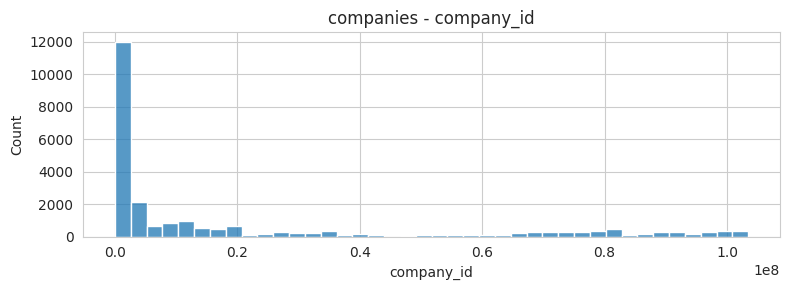

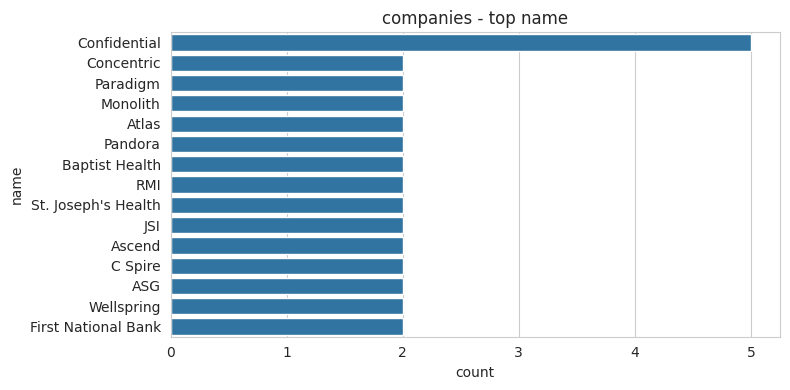


=== companies/company_industries.csv ===
shape (sample): (24375, 2)


,company_id,industry
0,391906,Book and Periodical Publishing
1,22292832,Construction
2,20300,Banking
3,3570660,Book and Periodical Publishing
4,878353,Staffing and Recruiting


,dtype,non_null,null_pct,unique
company_id,int64,24375,0.0,24365
industry,object,24375,0.0,144


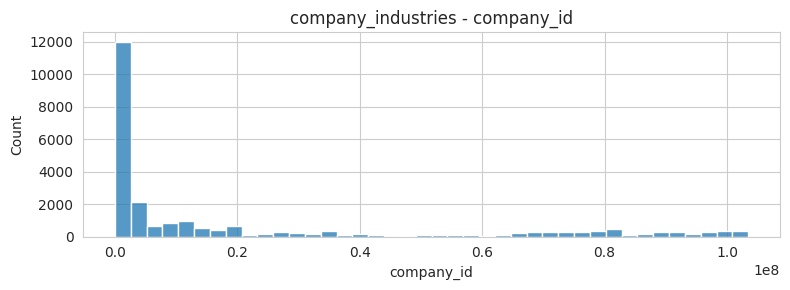

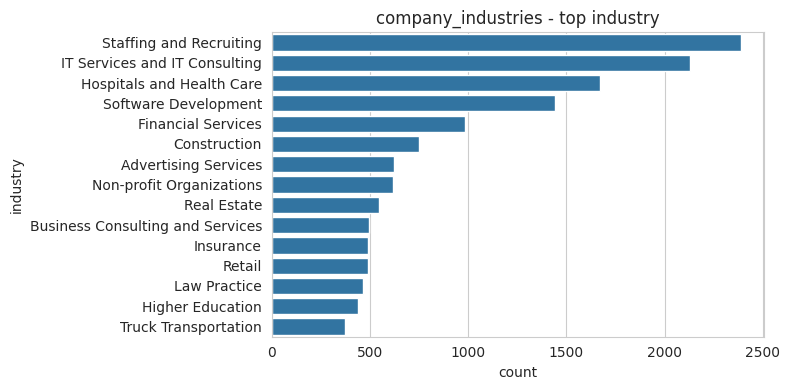


=== companies/company_specialities.csv ===
shape (sample): (150000, 2)


,company_id,speciality
0,22292832,window replacement
1,22292832,patio door replacement
2,20300,Commercial Banking
3,20300,Retail Banking
4,20300,Mortgage


,dtype,non_null,null_pct,unique
company_id,int64,150000,0.0,15752
speciality,object,150000,0.0,74567


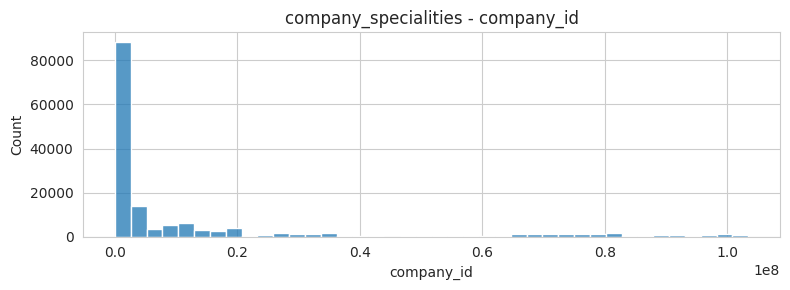

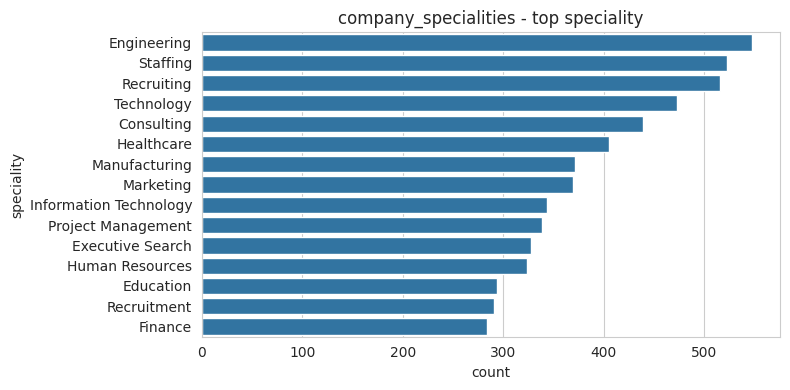


=== companies/employee_counts.csv ===
shape (sample): (35787, 4)


,company_id,employee_count,follower_count,time_recorded
0,391906,186,32508,1712346173
1,22292832,311,4471,1712346173
2,20300,1053,6554,1712346173
3,3570660,383,35241,1712346173
4,878353,52,26397,1712346173


,dtype,non_null,null_pct,unique
company_id,int64,35787,0.0,24473
employee_count,int64,35787,0.0,10033
follower_count,int64,35787,0.0,25554
time_recorded,int64,35787,0.0,3531


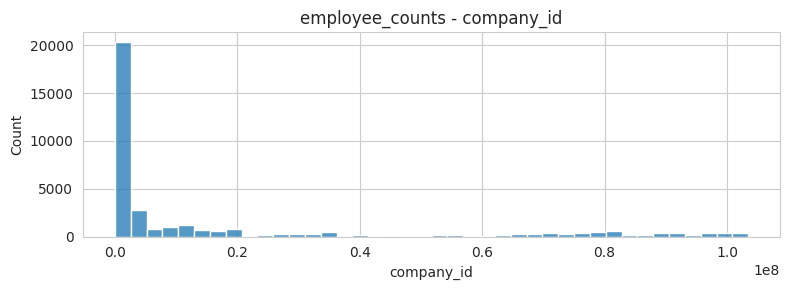


=== jobs/benefits.csv ===
shape (sample): (67943, 3)


,job_id,inferred,type
0,3887473071,0,Medical insurance
1,3887473071,0,Vision insurance
2,3887473071,0,Dental insurance
3,3887473071,0,401(k)
4,3887473071,0,Student loan assistance


,dtype,non_null,null_pct,unique
job_id,int64,67943,0.0,30023
inferred,int64,67943,0.0,2
type,object,67943,0.0,12


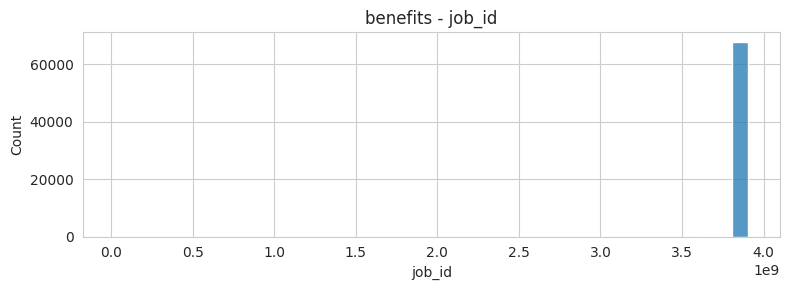

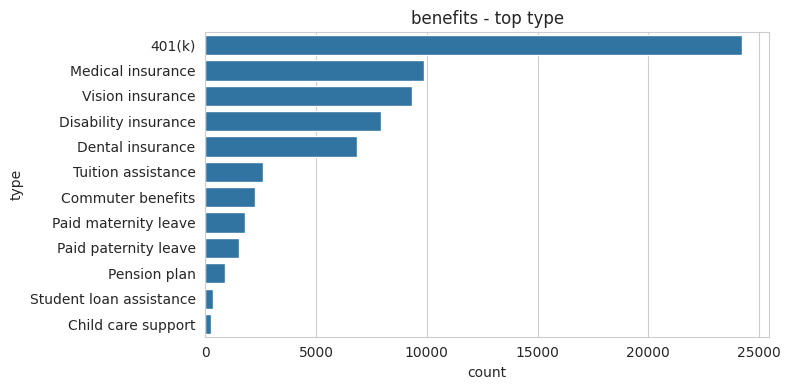


=== jobs/job_industries.csv ===
shape (sample): (150000, 2)


,job_id,industry_id
0,3884428798,82
1,3887473071,48
2,3887465684,41
3,3887467939,82
4,3887467939,80


,dtype,non_null,null_pct,unique
job_id,int64,150000,0.0,115918
industry_id,int64,150000,0.0,422


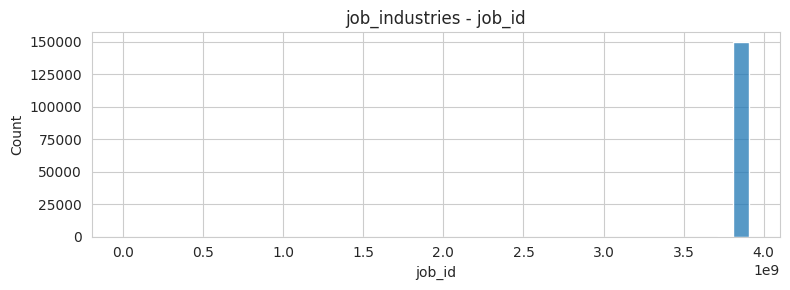


=== jobs/job_skills.csv ===
shape (sample): (150000, 2)
shape (sample): (150000, 2)


,job_id,skill_abr
0,3884428798,MRKT
1,3884428798,PR
2,3884428798,WRT
3,3887473071,SALE
4,3887465684,FIN


,dtype,non_null,null_pct,unique
job_id,int64,150000,0.0,89114
skill_abr,object,150000,0.0,35


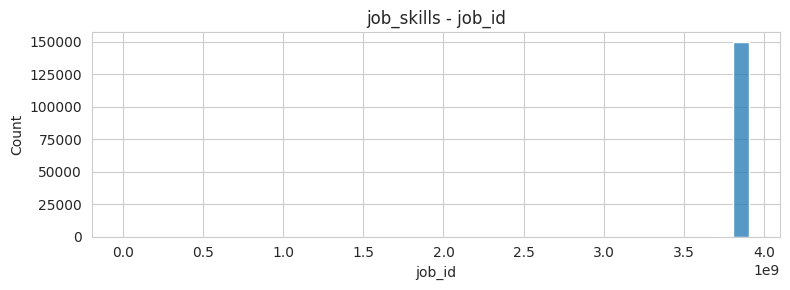

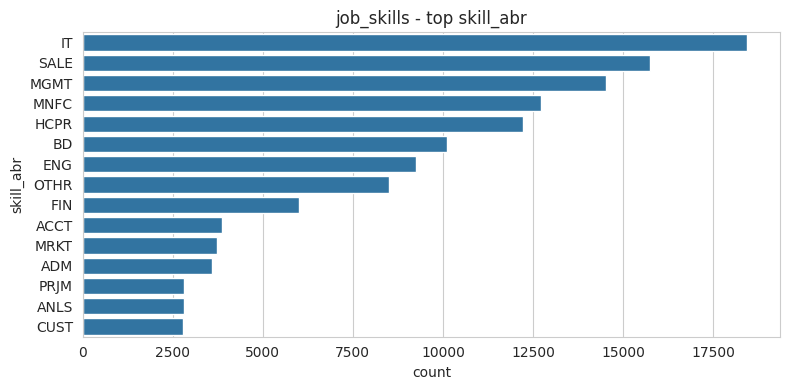


=== jobs/salaries.csv ===
shape (sample): (40785, 8)


,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency,compensation_type
0,1,3884428798,NaN,20.0,NaN,HOURLY,USD,BASE_SALARY
1,2,3887470552,25.0,NaN,23.0,HOURLY,USD,BASE_SALARY
2,3,3884431523,120000.0,NaN,100000.0,YEARLY,USD,BASE_SALARY
3,4,3884911725,200000.0,NaN,10000.0,YEARLY,USD,BASE_SALARY
4,5,3887473220,35.0,NaN,33.0,HOURLY,USD,BASE_SALARY


,dtype,non_null,null_pct,unique
med_salary,float64,6838,83.23,1417
max_salary,float64,33947,16.77,5321
min_salary,float64,33947,16.77,4620
job_id,int64,40785,0.00,40785
salary_id,int64,40785,0.00,40785
pay_period,object,40785,0.00,5
currency,object,40785,0.00,6
compensation_type,object,40785,0.00,1


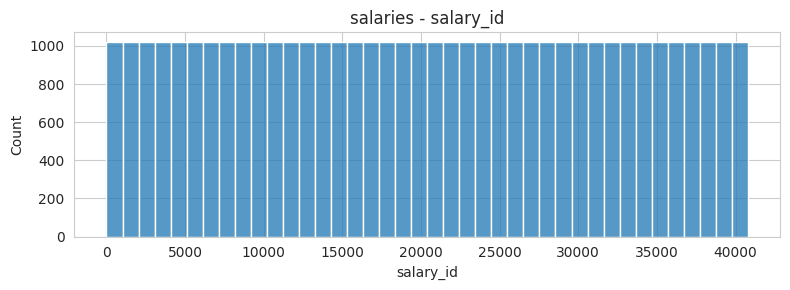

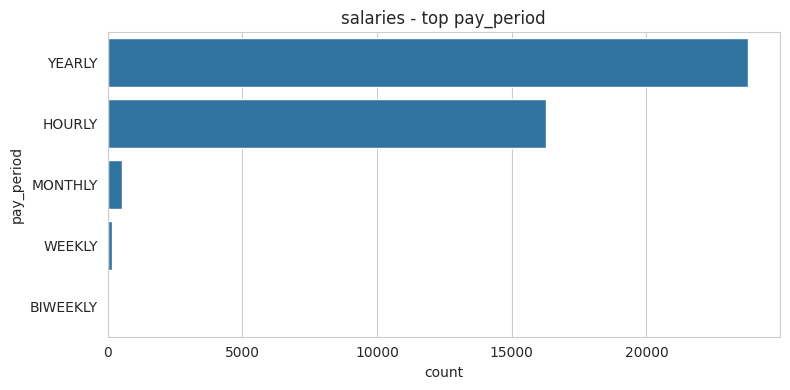


=== mappings/industries.csv ===
shape (sample): (422, 2)


,industry_id,industry_name
0,1,Defense and Space Manufacturing
1,3,Computer Hardware Manufacturing
2,4,Software Development
3,5,Computer Networking Products
4,6,"Technology, Information and Internet"


,dtype,non_null,null_pct,unique
industry_name,object,388,8.06,388
industry_id,int64,422,0.00,422


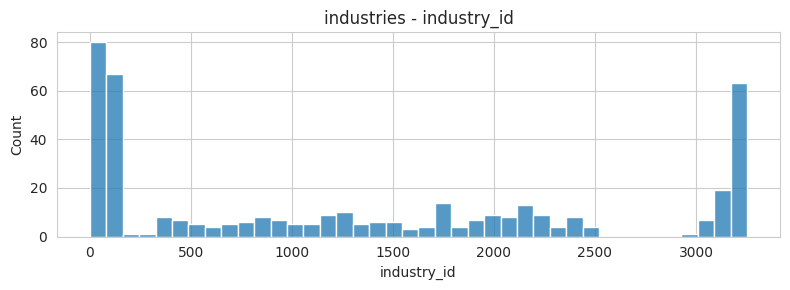

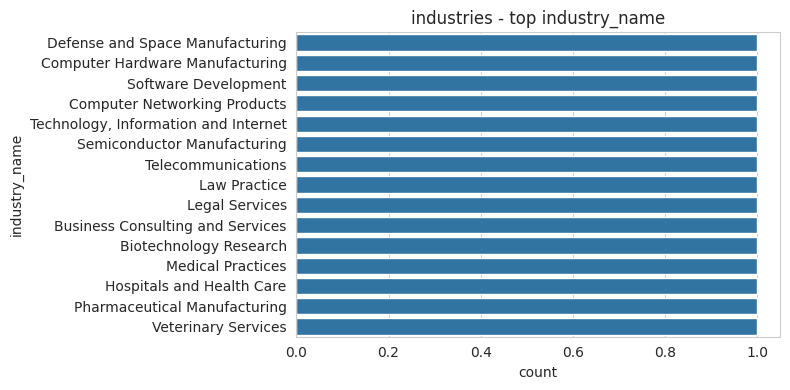


=== mappings/skills.csv ===
shape (sample): (35, 2)


,skill_abr,skill_name
0,ART,Art/Creative
1,DSGN,Design
2,ADVR,Advertising
3,PRDM,Product Management
4,DIST,Distribution


,dtype,non_null,null_pct,unique
skill_abr,object,35,0.0,35
skill_name,object,35,0.0,35


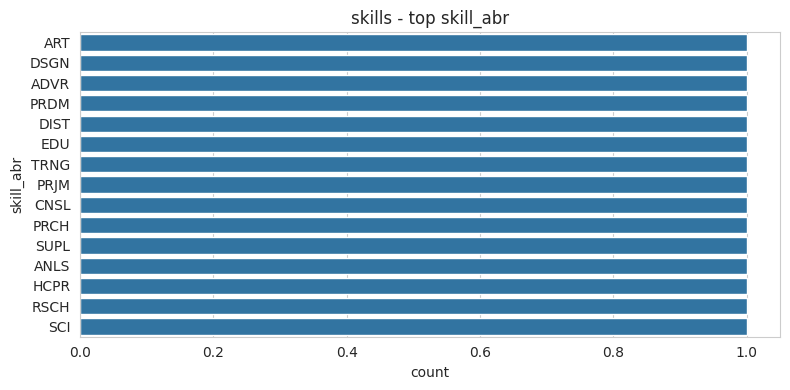


=== postings.csv ===
shape (sample): (123849, 31)
shape (sample): (123849, 31)


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,30.0,Full-time,NaN,1.712858e+12,NaN,https://www.linkedin.com/jobs/view/1829192/?tr...,NaN,ComplexOnsiteApply,1.715450e+12,NaN,NaN,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,45000.0,Full-time,NaN,1.713278e+12,NaN,https://www.linkedin.com/jobs/view/10998357/?t...,NaN,ComplexOnsiteApply,1.715870e+12,NaN,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,140000.0,Full-time,NaN,1.712896e+12,NaN,https://www.linkedin.com/jobs/view/23221523/?t...,NaN,ComplexOnsiteApply,1.715488e+12,NaN,NaN,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,60000.0,Full-time,NaN,1.713452e+12,NaN,https://www.linkedin.com/jobs/view/35982263/?t...,NaN,ComplexOnsiteApply,1.716044e+12,NaN,NaN,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


,dtype,non_null,null_pct,unique
closed_time,float64,1073,99.13,698
skills_desc,object,2439,98.03,2212
med_salary,float64,6280,94.93,1417
remote_allowed,float64,15246,87.69,1
applies,float64,23320,81.17,274
min_salary,float64,29793,75.94,4612
max_salary,float64,29793,75.94,5321
currency,object,36073,70.87,6
compensation_type,object,36073,70.87,1
pay_period,object,36073,70.87,5


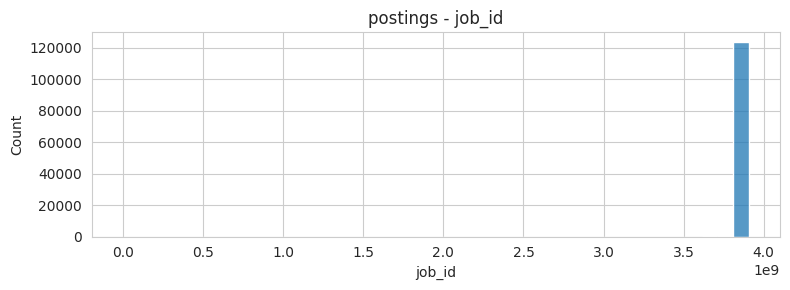

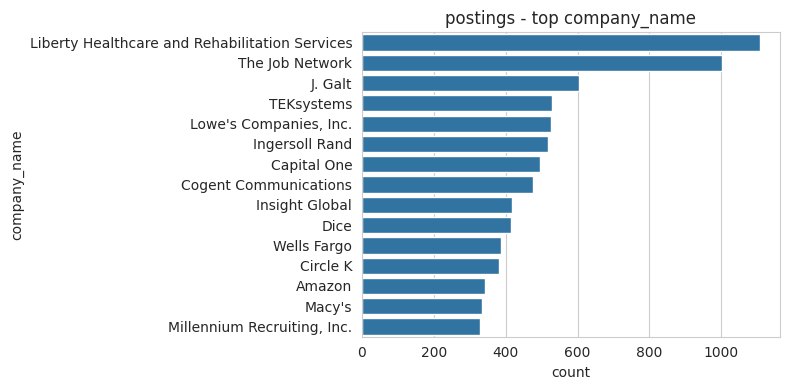

In [3]:
for p in csv_files:
    print(f"\n=== {p.relative_to(archive_dir)} ===")
    df = read_csv_sample(p)
    print("shape (sample):", df.shape)
    display(df.head())
    display(profile(df))
    plot_quick(df, p.stem)

## Key tables to feed loader.py

Load samples of the main tables we will likely join (`postings`, `companies`, `jobs` components, `mappings`) to inspect column names and keys for cleaning.


In [4]:
key_paths = {
    "postings": archive_dir / "postings.csv",
    "companies": archive_dir / "companies/companies.csv",
    "company_industries": archive_dir / "companies/company_industries.csv",
    "company_specialities": archive_dir / "companies/company_specialities.csv",
    "jobs_benefits": archive_dir / "jobs/benefits.csv",
    "jobs_industries": archive_dir / "jobs/job_industries.csv",
    "jobs_skills": archive_dir / "jobs/job_skills.csv",
    "jobs_salaries": archive_dir / "jobs/salaries.csv",
    "map_industries": archive_dir / "mappings/industries.csv",
    "map_skills": archive_dir / "mappings/skills.csv",
}

frames = {}
for name, path in key_paths.items():
    if not path.exists():
        print(f"Missing: {name} at {path}")
        continue
    nrows = sample_rows if name == "postings" else min(sample_rows, 50_000)
    frames[name] = read_csv_sample(path, nrows=nrows)
    print(f"{name}: {frames[name].shape} from {path.name}")
    display(frames[name].head())
    display(profile(frames[name]))

postings: (123849, 31) from postings.csv


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,30.0,Full-time,NaN,1.712858e+12,NaN,https://www.linkedin.com/jobs/view/1829192/?tr...,NaN,ComplexOnsiteApply,1.715450e+12,NaN,NaN,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,45000.0,Full-time,NaN,1.713278e+12,NaN,https://www.linkedin.com/jobs/view/10998357/?t...,NaN,ComplexOnsiteApply,1.715870e+12,NaN,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,140000.0,Full-time,NaN,1.712896e+12,NaN,https://www.linkedin.com/jobs/view/23221523/?t...,NaN,ComplexOnsiteApply,1.715488e+12,NaN,NaN,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,60000.0,Full-time,NaN,1.713452e+12,NaN,https://www.linkedin.com/jobs/view/35982263/?t...,NaN,ComplexOnsiteApply,1.716044e+12,NaN,NaN,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


,dtype,non_null,null_pct,unique
closed_time,float64,1073,99.13,698
skills_desc,object,2439,98.03,2212
med_salary,float64,6280,94.93,1417
remote_allowed,float64,15246,87.69,1
applies,float64,23320,81.17,274
min_salary,float64,29793,75.94,4612
max_salary,float64,29793,75.94,5321
currency,object,36073,70.87,6
compensation_type,object,36073,70.87,1
pay_period,object,36073,70.87,5


companies: (24473, 10) from companies.csv


,company_id,name,description,company_size,state,country,city,zip_code,address,url
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm
1,1016,GE HealthCare,Every day millions of people feel the impact o...,7.0,0,US,Chicago,0,-,https://www.linkedin.com/company/gehealthcare
2,1025,Hewlett Packard Enterprise,Official LinkedIn of Hewlett Packard Enterpris...,7.0,Texas,US,Houston,77389,1701 E Mossy Oaks Rd Spring,https://www.linkedin.com/company/hewlett-packa...
3,1028,Oracle,We’re a cloud technology company that provides...,7.0,Texas,US,Austin,78741,2300 Oracle Way,https://www.linkedin.com/company/oracle
4,1033,Accenture,Accenture is a leading global professional ser...,7.0,0,IE,Dublin 2,0,Grand Canal Harbour,https://www.linkedin.com/company/accenture


,dtype,non_null,null_pct,unique
company_size,float64,21699,11.33,7
description,object,24176,1.21,24164
zip_code,object,24445,0.11,7779
state,object,24451,0.09,788
address,object,24451,0.09,19476
company_id,int64,24473,0.00,24473
name,object,24472,0.00,24428
country,object,24473,0.00,81
city,object,24472,0.00,4124
url,object,24473,0.00,24473


company_industries: (24375, 2) from company_industries.csv


,company_id,industry
0,391906,Book and Periodical Publishing
1,22292832,Construction
2,20300,Banking
3,3570660,Book and Periodical Publishing
4,878353,Staffing and Recruiting


,dtype,non_null,null_pct,unique
company_id,int64,24375,0.0,24365
industry,object,24375,0.0,144


company_specialities: (50000, 2) from company_specialities.csv


,company_id,speciality
0,22292832,window replacement
1,22292832,patio door replacement
2,20300,Commercial Banking
3,20300,Retail Banking
4,20300,Mortgage


,dtype,non_null,null_pct,unique
company_id,int64,50000,0.0,5225
speciality,object,50000,0.0,28787


jobs_benefits: (50000, 3) from benefits.csv


,job_id,inferred,type
0,3887473071,0,Medical insurance
1,3887473071,0,Vision insurance
2,3887473071,0,Dental insurance
3,3887473071,0,401(k)
4,3887473071,0,Student loan assistance


,dtype,non_null,null_pct,unique
job_id,int64,50000,0.0,21850
inferred,int64,50000,0.0,2
type,object,50000,0.0,12


jobs_industries: (50000, 2) from job_industries.csv


,job_id,industry_id
0,3884428798,82
1,3887473071,48
2,3887465684,41
3,3887467939,82
4,3887467939,80


,dtype,non_null,null_pct,unique
job_id,int64,50000,0.0,39725
industry_id,int64,50000,0.0,378


jobs_skills: (50000, 2) from job_skills.csv


,job_id,skill_abr
0,3884428798,MRKT
1,3884428798,PR
2,3884428798,WRT
3,3887473071,SALE
4,3887465684,FIN


,dtype,non_null,null_pct,unique
job_id,int64,50000,0.0,30181
skill_abr,object,50000,0.0,35


jobs_salaries: (40785, 8) from salaries.csv


,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency,compensation_type
0,1,3884428798,NaN,20.0,NaN,HOURLY,USD,BASE_SALARY
1,2,3887470552,25.0,NaN,23.0,HOURLY,USD,BASE_SALARY
2,3,3884431523,120000.0,NaN,100000.0,YEARLY,USD,BASE_SALARY
3,4,3884911725,200000.0,NaN,10000.0,YEARLY,USD,BASE_SALARY
4,5,3887473220,35.0,NaN,33.0,HOURLY,USD,BASE_SALARY


,dtype,non_null,null_pct,unique
med_salary,float64,6838,83.23,1417
max_salary,float64,33947,16.77,5321
min_salary,float64,33947,16.77,4620
job_id,int64,40785,0.00,40785
salary_id,int64,40785,0.00,40785
pay_period,object,40785,0.00,5
currency,object,40785,0.00,6
compensation_type,object,40785,0.00,1


map_industries: (422, 2) from industries.csv


,industry_id,industry_name
0,1,Defense and Space Manufacturing
1,3,Computer Hardware Manufacturing
2,4,Software Development
3,5,Computer Networking Products
4,6,"Technology, Information and Internet"


,dtype,non_null,null_pct,unique
industry_name,object,388,8.06,388
industry_id,int64,422,0.00,422


map_skills: (35, 2) from skills.csv


,skill_abr,skill_name
0,ART,Art/Creative
1,DSGN,Design
2,ADVR,Advertising
3,PRDM,Product Management
4,DIST,Distribution


,dtype,non_null,null_pct,unique
skill_abr,object,35,0.0,35
skill_name,object,35,0.0,35


## Next steps for cleaning

- Decide join keys (e.g., `job_id`, `company_id`) from the previews above.
- Drop or fill high-null columns; deduplicate by ids.
- Standardize text fields (`job_title`, `description`, `skills`) for vectorization.
- Save a cleaned, joined table to `data/processed/clean_jobs.csv` for use in `src/loader.py`.


## Thiết lập thư mục dữ liệu (Day 1)

Đảm bảo tồn tại `data/raw` và `data/processed`, đồng thời sao chép snapshot từ `data/archive` để các bước làm sạch không ảnh hưởng dữ liệu gốc.


In [5]:
from pathlib import Path
import shutil

project_root = (Path.cwd() / "..").resolve()
data_dir = project_root / "data"
archive_dir = data_dir / "archive"  # cập nhật lại biến để chắc chắn dùng đúng đường dẫn
raw_dir = data_dir / "raw"
processed_dir = data_dir / "processed"

raw_dir.mkdir(parents=True, exist_ok=True)
processed_dir.mkdir(parents=True, exist_ok=True)


def sync_archive(src: Path, dst: Path, overwrite: bool = False) -> int:
    """Copy toàn bộ file từ src sang dst (bỏ qua file đã tồn tại khi overwrite=False)."""
    copied = 0
    for item in src.rglob("*"):
        rel = item.relative_to(src)
        target = dst / rel
        if item.is_dir():
            target.mkdir(parents=True, exist_ok=True)
            continue
        if target.exists() and not overwrite:
            continue
        target.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(item, target)
        copied += 1
    return copied


copied_files = sync_archive(archive_dir, raw_dir)
print(f"Synced archive -> raw ({copied_files} files copied).")
print(f"Raw dir: {raw_dir}")
print(f"Processed dir: {processed_dir}")

Synced archive -> raw (0 files copied).
Raw dir: /home/sakana/Code/DS-RS/data/raw
Processed dir: /home/sakana/Code/DS-RS/data/processed


## Audit chi tiết `postings.csv`

Tính toán tỷ lệ thiếu dữ liệu và các phân bố chính để định hướng bước làm sạch.


In [6]:
postings_path = archive_dir / "postings.csv"
postings_df = pd.read_csv(postings_path)

missing_pct = (postings_df.isna().mean() * 100).sort_values(ascending=False)
pay_dist = postings_df["pay_period"].fillna("Missing").value_counts()
work_type_dist = postings_df["formatted_work_type"].fillna("Missing").value_counts()
remote_dist = postings_df["remote_allowed"].fillna("Missing").value_counts()
location_top = postings_df["location"].fillna("Unknown").value_counts().head(10)

postings_summary = {
    "rows": len(postings_df),
    "cols": postings_df.shape[1],
    "missing_top": missing_pct.head(10),
    "pay_dist": pay_dist,
    "work_type_dist": work_type_dist,
    "remote_dist": remote_dist,
    "location_top": location_top,
}

print(
    f"Tổng quan postings: {postings_summary['rows']:,} dòng / {postings_summary['cols']} cột"
)
display(postings_summary["missing_top"].to_frame("pct_missing"))
display(postings_summary["pay_dist"].to_frame("count"))
display(postings_summary["work_type_dist"].to_frame("count"))
display(postings_summary["remote_dist"].to_frame("count"))
display(postings_summary["location_top"].to_frame("count"))

Tổng quan postings: 123,849 dòng / 31 cột


,pct_missing
closed_time,99.133622
skills_desc,98.030666
med_salary,94.929309
remote_allowed,87.689848
applies,81.170619
min_salary,75.944093
max_salary,75.944093
currency,70.873402
compensation_type,70.873402
pay_period,70.873402


,count
pay_period,
Missing,87776
YEARLY,20628
HOURLY,14741
MONTHLY,518
WEEKLY,177
BIWEEKLY,9


,count
formatted_work_type,
Full-time,98814
Contract,12117
Part-time,9696
Temporary,1190
Internship,983
Volunteer,562
Other,487


,count
remote_allowed,
Missing,108603
1.0,15246


,count
location,
United States,8125
"New York, NY",2756
"Chicago, IL",1834
"Houston, TX",1762
"Dallas, TX",1383
"Atlanta, GA",1363
"Boston, MA",1176
"Austin, TX",1083
"Charlotte, NC",1075


## Thống kê kỹ năng, ngành và lương

Ghép với bảng mapping để xem top skill/industry, đồng thời tóm tắt phân bố lương.


In [7]:
skills_df = pd.read_csv(archive_dir / "jobs/job_skills.csv")
skill_map = pd.read_csv(archive_dir / "mappings/skills.csv").set_index("skill_abr")[
    "skill_name"
]
skill_counts_named = (
    skills_df["skill_abr"].map(skill_map).fillna("Unknown").value_counts()
)
display(skill_counts_named.head(10).to_frame("count"))

industries_df = pd.read_csv(archive_dir / "jobs/job_industries.csv")
industry_map = pd.read_csv(archive_dir / "mappings/industries.csv").set_index(
    "industry_id"
)["industry_name"]
industry_counts_named = (
    industries_df["industry_id"].map(industry_map).fillna("Unknown").value_counts()
)
display(industry_counts_named.head(10).to_frame("count"))

salaries_df = pd.read_csv(archive_dir / "jobs/salaries.csv")
salaries_df["min_salary"] = pd.to_numeric(salaries_df["min_salary"], errors="coerce")
salaries_df["max_salary"] = pd.to_numeric(salaries_df["max_salary"], errors="coerce")
salaries_df["med_salary"] = pd.to_numeric(salaries_df["med_salary"], errors="coerce")
salary_dist = salaries_df["pay_period"].value_counts()
salary_stats = {
    "avg_min": salaries_df["min_salary"].mean(),
    "avg_max": salaries_df["max_salary"].mean(),
    "avg_med": salaries_df["med_salary"].mean(),
}
display(salary_dist.to_frame("count"))
print("Trung bình min_salary: {0:,.0f}".format(salary_stats["avg_min"]))
print("Trung bình max_salary: {0:,.0f}".format(salary_stats["avg_max"]))
print("Trung bình med_salary: {0:,.0f}".format(salary_stats["avg_med"]))

,count
skill_abr,
Information Technology,26137
Sales,22475
Management,20861
Manufacturing,18185
Health Care Provider,17369
Business Development,14290
Engineering,13009
Other,12608
Finance,8540


,count
industry_id,
Hospitals and Health Care,18326
Retail,11033
IT Services and IT Consulting,10396
Staffing and Recruiting,9005
Financial Services,8535
Software Development,5091
Manufacturing,3689
Construction,3445
Banking,2923


,count
pay_period,
YEARLY,23768
HOURLY,16289
MONTHLY,539
WEEKLY,180
BIWEEKLY,9


Trung bình min_salary: 65,085
Trung bình max_salary: 96,210
Trung bình med_salary: 21,370


## Thống kê benefits & metadata công ty

Coverage của phúc lợi và mô tả doanh nghiệp giúp xác định những trường cần làm sạch cũng như thông tin nào có thể đưa vào giao diện gợi ý.


In [8]:
benefits_df = pd.read_csv(archive_dir / 'jobs/benefits.csv')
benefits_df['type'] = benefits_df['type'].fillna('Unknown')
benefit_counts = benefits_df['type'].value_counts()
jobs_with_benefit = benefits_df['job_id'].nunique()
benefit_summary = {
    'rows': len(benefits_df),
    'jobs_with_benefit': jobs_with_benefit,
    'coverage_pct': (jobs_with_benefit / postings_summary['rows']) * 100,
    'avg_per_job': benefit_counts.sum() / jobs_with_benefit if jobs_with_benefit else 0.0,
    'top_benefits': benefit_counts,
}
display(benefit_counts.head(10).to_frame('count'))
print(
    f"Jobs có >=1 benefit: {benefit_summary['jobs_with_benefit']:,} "
    f"({benefit_summary['coverage_pct']:.1f}% data)"
)
print(f"Trung bình số benefit/job: {benefit_summary['avg_per_job']:.2f}")

companies_df = pd.read_csv(archive_dir / 'companies/companies.csv')
company_summary = {
    'rows': len(companies_df),
    'country_dist': companies_df['country'].fillna('Unknown').value_counts(),
    'state_dist': companies_df['state'].fillna('Unknown').value_counts(),
    'size_dist': companies_df['company_size'].fillna('Unknown').value_counts(),
}
company_specialities = pd.read_csv(archive_dir / 'companies/company_specialities.csv')
company_summary['specialities'] = company_specialities['speciality'].value_counts()
employee_counts = pd.read_csv(archive_dir / 'companies/employee_counts.csv')
employee_counts['employee_count'] = pd.to_numeric(employee_counts['employee_count'], errors='coerce')
employee_counts['follower_count'] = pd.to_numeric(employee_counts['follower_count'], errors='coerce')
company_summary['employee_company_count'] = employee_counts['company_id'].nunique()
company_summary['employee_avg'] = employee_counts['employee_count'].mean()
company_summary['follower_avg'] = employee_counts['follower_count'].mean()
display(company_summary['country_dist'].head(5).to_frame('count'))
display(company_summary['state_dist'].head(5).to_frame('count'))
display(company_summary['size_dist'].head(5).to_frame('count'))
display(company_summary['specialities'].head(10).to_frame('count'))
print(
    f"Companies tracked: {company_summary['rows']:,} | "
    f"employee_count records: {company_summary['employee_company_count']:,}"
)


,count
type,
401(k),24231
Medical insurance,9873
Vision insurance,9309
Disability insurance,7930
Dental insurance,6868
Tuition assistance,2614
Commuter benefits,2226
Paid maternity leave,1808
Paid paternity leave,1540


Jobs có >=1 benefit: 30,023 (24.2% data)
Trung bình số benefit/job: 2.26


,count
country,
US,21635
0,727
GB,620
CA,258
IN,157


,count
state,
0,2175
California,1747
CA,1401
Texas,1276
NY,977


,count
company_size,
2.0,4956
1.0,4348
5.0,3918
3.0,3108
Unknown,2774


,count
speciality,
Engineering,601
Recruiting,581
Staffing,578
Technology,529
Consulting,492
Healthcare,445
Manufacturing,420
Marketing,416
Project Management,379


Companies tracked: 24,473 | employee_count records: 24,473


## Ghi báo cáo audit Day 1

Tổng hợp các thống kê ở trên và lưu lại `reports/data_audit.md` làm reference cho team.


---

# Day 2: Data Cleaning Pipeline

Execute the complete cleaning workflow using the functions built in `src/preprocessing.py` and `src/loader.py`.

## Test cleaning functions

Verify that text cleaning, location parsing, and other preprocessing functions work correctly.

In [9]:
import sys
sys.path.insert(0, str(project_root / 'src'))

# Import without relative paths - notebook context requires absolute imports
import preprocessing
import loader

# Test text cleaning
test_texts = [
    "<p>Looking for a <b>Python Developer</b> with 3+ years exp.</p>",
    "Join our team! Visit https://example.com for more info\n\nGreat benefits!",
    "Développeur Python • Expert en IA/ML",
]

print("=== Text Cleaning Tests ===")
for i, text in enumerate(test_texts, 1):
    cleaned = preprocessing.clean_text(text)
    print(f"\n{i}. Original: {text}")
    print(f"   Cleaned:  {cleaned}")

# Test location parsing
test_locations = [
    "New York, NY",
    "United States",
    "London, England",
    "San Francisco, CA",
    "Toronto, ON, Canada",
]

print("\n\n=== Location Parsing Tests ===")
for loc in test_locations:
    parsed = preprocessing.parse_location(loc)
    print(f"{loc:30} -> {parsed}")

=== Text Cleaning Tests ===

1. Original: <p>Looking for a <b>Python Developer</b> with 3+ years exp.</p>
   Cleaned:  looking for a python developer with 3 years exp

2. Original: Join our team! Visit https://example.com for more info

Great benefits!
   Cleaned:  join our team visit for more info great benefits

3. Original: Développeur Python • Expert en IA/ML
   Cleaned:  developpeur python expert en ia ml


=== Location Parsing Tests ===
New York, NY                   -> {'city': 'New York', 'state': 'NY', 'country': 'United States'}
United States                  -> {'city': None, 'state': None, 'country': 'United States'}
London, England                -> {'city': 'London', 'state': None, 'country': 'England'}
San Francisco, CA              -> {'city': 'San Francisco', 'state': 'CA', 'country': 'United States'}
Toronto, ON, Canada            -> {'city': 'Toronto', 'state': 'ON', 'country': 'Canada'}


## Run full cleaning pipeline on sample

Test the complete pipeline on a small sample before running on full dataset.

In [10]:
from loader import build_and_clean_jobs

# Test on 5000 rows first
print("Testing pipeline on 5,000 job sample...")
sample_cleaned = build_and_clean_jobs(sample=5000, persist=False)

print(f"\n{'='*60}")
print("Sample output:")
print(f"{'='*60}")
display(sample_cleaned.head())

print(f"\n{'='*60}")
print("Cleaned columns:")
print(f"{'='*60}")
print(sample_cleaned.columns.tolist())

print(f"\n{'='*60}")
print("Data quality summary:")
print(f"{'='*60}")
quality_metrics = {
    'total_rows': len(sample_cleaned),
    'has_content': (sample_cleaned['content'].str.len() > 0).sum(),
    'has_skills': sample_cleaned['skills'].notna().sum(),
    'has_industries': sample_cleaned['industries'].notna().sum(),
    'has_location_parsed': sample_cleaned['country'].notna().sum(),
    'has_salary_info': sample_cleaned['has_salary_info'].sum() if 'has_salary_info' in sample_cleaned.columns else 0,
}

for metric, value in quality_metrics.items():
    pct = (value / quality_metrics['total_rows']) * 100 if quality_metrics['total_rows'] else 0
    print(f"{metric:25}: {value:6,} ({pct:5.1f}%)")

Testing pipeline on 5,000 job sample...
Step 1: Building enriched jobs dataset...

Step 2: Applying cleaning pipeline to 5,000 jobs...
Starting with 5,000 rows...
Cleaning text field: title
Cleaning text field: description

Step 2: Applying cleaning pipeline to 5,000 jobs...
Starting with 5,000 rows...
Cleaning text field: title
Cleaning text field: description
Cleaning text field: skills_desc
Created combined 'content' field
Parsing location field...
Created normalized_salary field
Cleaning complete. Final dataset: 5,000 rows

Sample output:
Cleaning text field: skills_desc
Created combined 'content' field
Parsing location field...
Created normalized_salary field
Cleaning complete. Final dataset: 5,000 rows

Sample output:


,job_id,company_name_x,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,...,salary_type,company_name_y,company_description,company_size,company_state,company_country,company_city,company_zip,company_url,company_specialities,company_industries,company_employee_count,company_follower_count,time_recorded,title_clean,description_clean,skills_desc_clean,content,city,state,country,experience_level,has_salary_info,has_remote_flag,is_remote
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,...,BASE_SALARY,Corcoran Sawyer Smith,With years of experience helping local buyers ...,2.0,NJ,US,Jersey City,07302,https://www.linkedin.com/company/corcoran-sawy...,"new development, real estate",Real Estate,402.0,2351.0,1.713409e+09,marketing coordinator,job descriptiona leading real estate firm in n...,requirements we are seeking a college or gradu...,marketing coordinator marketing coordinator jo...,Princeton,NJ,United States,Unknown,1,0,0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",<NA>,1.0,NaN,30.0,Full-time,NaN,1.712858e+12,NaN,https://www.linkedin.com/jobs/view/1829192/?tr...,NaN,ComplexOnsiteApply,1.715450e+12,NaN,NaN,NaN,1.712858e+12,NaN,0,...,BASE_SALARY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mental health therapist counselor,at aspen therapy and wellness we are committed...,,mental health therapist counselor mental healt...,Fort Collins,CO,United States,Unknown,1,0,0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719,8.0,NaN,45000.0,Full-time,NaN,1.713278e+12,NaN,https://www.linkedin.com/jobs/view/10998357/?t...,NaN,ComplexOnsiteApply,1.715870e+12,NaN,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,...,BASE_SALARY,The National Exemplar,"In April of 1983, The National Exemplar began ...",1.0,Ohio,US,Mariemont,45227,https://www.linkedin.com/company/the-national-...,NaN,Restaurants,15.0,40.0,1.713279e+09,assitant restaurant manager,the national exemplar is accepting application...,we are currently accepting resumes for foh asi...,assitant restaurant manager assitant restauran...,Cincinnati,OH,United States,Unknown,1,0,0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262,16.0,NaN,140000.0,Full-time,NaN,1.712896e+12,NaN,https://www.linkedin.com/jobs/view/23221523/?t...,NaN,ComplexOnsiteApply,1.715488e+12,NaN,NaN,This position requires a baseline understandin...,1.712896e+12,NaN,0,...,BASE_SALARY,"Abrams Fensterman, LLP","Abrams Fensterman, LLP is a full-service law f...",2.0,New York,US,Lake Success,11042,https://www.linkedin.com/company/abrams-fenste...,"Appellate, Civil Litigation, Corporate & Secur...",Law Practice,222.0,2427.0,1.712897e+09,senior elder law trusts and estates associate ...,senior associate attorney elder law trusts and...,this position requires a baseline understandin...,senior elder law trusts and estates associate ...,New Hyde Park,NY,United States,Unknown,1,0,0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",<NA>,3.0,NaN,60000.0,Full-time,NaN,1.713452e+12,NaN,https://www.linkedin.com/jobs/view/35982263/?t...,NaN,ComplexOnsiteApply,1.716044e+12,NaN,NaN,NaN,1.713452e+12,NaN,


Cleaned columns:
['job_id', 'company_name_x', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'zip_code', 'fips', 'skills', 'industries', 'benefits', 'salary_min', 'salary_median', 'salary_max', 'salary_currency', 'salary_period', 'salary_type', 'company_name_y', 'company_description', 'company_size', 'company_state', 'company_country', 'company_city', 'company_zip', 'company_url', 'company_specialities', 'company_industries', 'company_employee_count', 'company_follower_count', 'time_recorded', 'title_clean', 'description_clean', 'skills_desc_clean', 'content', 'city', 'state', 'country', 'experience_level',

## Inspect cleaned content examples

Look at actual examples of cleaned job descriptions to verify quality.

In [11]:
# Show a few examples of original vs cleaned content
examples = sample_cleaned[sample_cleaned['content'].str.len() > 100].head(3)

for idx, row in examples.iterrows():
    print(f"\n{'='*80}")
    print(f"Job ID: {row.get('job_id', 'N/A')}")
    print(f"Title: {row.get('title', 'N/A')}")
    print(f"Skills: {row.get('skills', 'N/A')}")
    print(f"Industries: {row.get('industries', 'N/A')}")
    print(f"Location: {row.get('city', 'N/A')}, {row.get('state', 'N/A')}, {row.get('country', 'N/A')}")
    print(f"\nOriginal description (first 200 chars):")
    print(row.get('description', 'N/A')[:200] + "...")
    print(f"\nCleaned content (first 300 chars):")
    print(row.get('content', 'N/A')[:300] + "...")
    print(f"{'='*80}")


Job ID: 921716
Title: Marketing Coordinator
Skills: Marketing, Sales
Industries: Real Estate
Location: Princeton, NJ, United States

Original description (first 200 chars):
Job descriptionA leading real estate firm in New Jersey is seeking an administrative Marketing Coordinator with some experience in graphic design. You will be working closely with our fun, kind, ambit...

Cleaned content (first 300 chars):
marketing coordinator marketing coordinator job descriptiona leading real estate firm in new jersey is seeking an administrative marketing coordinator with some experience in graphic design you will be working closely with our fun kind ambitious members of the sales team and our dynamic executive te...

Job ID: 1829192
Title: Mental Health Therapist/Counselor
Skills: Health Care Provider
Industries: nan
Location: Fort Collins, CO, United States

Original description (first 200 chars):
At Aspen Therapy and Wellness , we are committed to serving clients with best practices to help 

## Process FULL dataset and save

**Warning:** This will process all ~124K jobs. It may take 5-10 minutes depending on your machine.

Run this cell only after verifying the sample results above look good.

In [12]:
import time

print("Starting FULL dataset cleaning pipeline...")
print("This may take several minutes. Please wait...\n")

start_time = time.time()

# Process full dataset and save to parquet
full_cleaned = build_and_clean_jobs(
    sample=None,  # Process all rows
    persist=True,  # Save to data/processed/clean_jobs.parquet
    output_name="clean_jobs.parquet"
)

elapsed = time.time() - start_time
print(f"\n{'='*60}")
print(f"✓ COMPLETE in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
print(f"{'='*60}")
print(f"Final dataset shape: {full_cleaned.shape}")
print(f"Saved to: {processed_dir / 'clean_jobs.parquet'}")
print(f"File size: {(processed_dir / 'clean_jobs.parquet').stat().st_size / 1e6:.1f} MB")

Starting FULL dataset cleaning pipeline...
This may take several minutes. Please wait...

Step 1: Building enriched jobs dataset...

Step 2: Applying cleaning pipeline to 123,849 jobs...
Starting with 123,849 rows...

Step 2: Applying cleaning pipeline to 123,849 jobs...
Starting with 123,849 rows...
Dropped 7 rows with missing/empty 'description'
Cleaning text field: title
Dropped 7 rows with missing/empty 'description'
Cleaning text field: title
Cleaning text field: description
Cleaning text field: description
Cleaning text field: skills_desc
Cleaning text field: skills_desc
Created combined 'content' field
Parsing location field...
Created combined 'content' field
Parsing location field...
Created normalized_salary field
Cleaning complete. Final dataset: 123,842 rows
Created normalized_salary field
Cleaning complete. Final dataset: 123,842 rows


ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

## Final data quality validation

Generate summary statistics and visualizations for the cleaned dataset.

In [ ]:
# Comprehensive quality metrics
print("="*80)
print("CLEANED DATASET QUALITY REPORT")
print("="*80)

# Basic stats
print(f"\nDataset Overview:")
print(f"  Total jobs: {len(full_cleaned):,}")
print(f"  Total columns: {len(full_cleaned.columns)}")
print(f"  Memory usage: {full_cleaned.memory_usage(deep=True).sum() / 1e6:.1f} MB")

# Content quality
print(f"\nContent Quality:")
content_stats = {
    'Has content field': 'content' in full_cleaned.columns,
    'Non-empty content': (full_cleaned['content'].str.len() > 0).sum() if 'content' in full_cleaned.columns else 0,
    'Avg content length': full_cleaned['content'].str.len().mean() if 'content' in full_cleaned.columns else 0,
    'Min content length': full_cleaned['content'].str.len().min() if 'content' in full_cleaned.columns else 0,
    'Max content length': full_cleaned['content'].str.len().max() if 'content' in full_cleaned.columns else 0,
}
for k, v in content_stats.items():
    if isinstance(v, bool):
        print(f"  {k}: {v}")
    elif isinstance(v, (int, float)) and k == 'Non-empty content':
        pct = (v / len(full_cleaned)) * 100
        print(f"  {k}: {v:,} ({pct:.1f}%)")
    elif isinstance(v, float):
        print(f"  {k}: {v:.1f}")
    else:
        print(f"  {k}: {v:,}")

# Feature completeness
print(f"\nFeature Completeness:")
feature_coverage = {
    'skills': full_cleaned['skills'].notna().sum(),
    'industries': full_cleaned['industries'].notna().sum(),
    'benefits': full_cleaned['benefits'].notna().sum() if 'benefits' in full_cleaned.columns else 0,
    'city': full_cleaned['city'].notna().sum() if 'city' in full_cleaned.columns else 0,
    'state': full_cleaned['state'].notna().sum() if 'state' in full_cleaned.columns else 0,
    'country': full_cleaned['country'].notna().sum() if 'country' in full_cleaned.columns else 0,
}
for feature, count in feature_coverage.items():
    pct = (count / len(full_cleaned)) * 100
    print(f"  {feature:15}: {count:6,} ({pct:5.1f}%)")

# Categorical distributions
print(f"\nKey Distributions:")
if 'work_type' in full_cleaned.columns:
    print(f"\n  Work Type:")
    work_dist = full_cleaned['work_type'].value_counts().head(5)
    for wt, cnt in work_dist.items():
        pct = (cnt / len(full_cleaned)) * 100
        print(f"    {wt:20}: {cnt:6,} ({pct:5.1f}%)")

if 'country' in full_cleaned.columns:
    print(f"\n  Top Countries:")
    country_dist = full_cleaned['country'].value_counts().head(5)
    for country, cnt in country_dist.items():
        pct = (cnt / len(full_cleaned)) * 100
        print(f"    {country:20}: {cnt:6,} ({pct:5.1f}%)")

# Missing data
print(f"\nMissing Data (top 10 fields):")
missing_pct = (full_cleaned.isna().mean() * 100).sort_values(ascending=False).head(10)
for col, pct in missing_pct.items():
    print(f"  {col:30}: {pct:5.1f}%")

print("\n" + "="*80)

## Visualize cleaning results

Create plots showing the distribution of cleaned data.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Content length distribution
if 'content' in full_cleaned.columns:
    content_lengths = full_cleaned['content'].str.len()
    axes[0, 0].hist(content_lengths[content_lengths > 0], bins=50, edgecolor='black')
    axes[0, 0].set_xlabel('Content Length (characters)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Cleaned Content Length')
    axes[0, 0].axvline(content_lengths.mean(), color='red', linestyle='--', label=f'Mean: {content_lengths.mean():.0f}')
    axes[0, 0].legend()

# 2. Work type distribution
if 'work_type' in full_cleaned.columns:
    work_counts = full_cleaned['work_type'].value_counts().head(8)
    axes[0, 1].barh(range(len(work_counts)), work_counts.values)
    axes[0, 1].set_yticks(range(len(work_counts)))
    axes[0, 1].set_yticklabels(work_counts.index)
    axes[0, 1].set_xlabel('Count')
    axes[0, 1].set_title('Work Type Distribution')
    axes[0, 1].invert_yaxis()

# 3. Feature completeness
feature_names = ['skills', 'industries', 'benefits', 'city', 'country']
available_features = [f for f in feature_names if f in full_cleaned.columns]
completeness = [(full_cleaned[f].notna().sum() / len(full_cleaned)) * 100 for f in available_features]
axes[1, 0].bar(available_features, completeness, color='steelblue', edgecolor='black')
axes[1, 0].set_ylabel('Completeness (%)')
axes[1, 0].set_title('Feature Completeness After Cleaning')
axes[1, 0].set_ylim(0, 100)
axes[1, 0].axhline(50, color='red', linestyle='--', alpha=0.5)
for i, (feature, pct) in enumerate(zip(available_features, completeness)):
    axes[1, 0].text(i, pct + 2, f'{pct:.1f}%', ha='center', va='bottom')

# 4. Top countries
if 'country' in full_cleaned.columns:
    country_counts = full_cleaned['country'].value_counts().head(10)
    axes[1, 1].barh(range(len(country_counts)), country_counts.values, color='coral', edgecolor='black')
    axes[1, 1].set_yticks(range(len(country_counts)))
    axes[1, 1].set_yticklabels(country_counts.index)
    axes[1, 1].set_xlabel('Number of Jobs')
    axes[1, 1].set_title('Top 10 Countries')
    axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig(project_root / 'images' / 'data_cleaning_summary.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved visualization to images/data_cleaning_summary.png")
plt.show()

## Generate cleaning report

Save a summary report documenting the cleaning process and results.

In [ ]:
from datetime import datetime

cleaning_report = f"""# Data Cleaning Report – Day 2

**Project:** Intelligent Job Matching System  
**Date:** {datetime.utcnow().date()}  
**Notebook:** `notebooks/1_data_cleaning.ipynb`

---

## Overview

This report documents the data cleaning process completed on Day 2 of the project timeline.

### Pipeline Steps

1. **Text Normalization**
   - Removed HTML tags and URLs
   - Normalized Unicode characters to ASCII
   - Converted to lowercase
   - Removed special characters and punctuation
   - Collapsed whitespace
   - Optional stopword removal

2. **Location Standardization**
   - Parsed location strings into city, state, and country components
   - Standardized US state codes
   - Filled missing values with "Unknown"

3. **Data Quality Improvements**
   - Removed jobs missing title or description: {postings_summary['rows'] - len(full_cleaned):,} jobs
   - Deduplicated by job_id
   - Created combined 'content' field for vectorization

4. **Feature Engineering**
   - Binary flags: `has_salary_info`, `has_remote_flag`, `is_remote`
   - Normalized salary to yearly equivalent
   - Parsed location into city/state/country

---

## Results

### Dataset Summary

- **Original size:** {postings_summary['rows']:,} jobs
- **After cleaning:** {len(full_cleaned):,} jobs
- **Reduction:** {postings_summary['rows'] - len(full_cleaned):,} jobs ({((postings_summary['rows'] - len(full_cleaned)) / postings_summary['rows'] * 100):.1f}%)
- **Final columns:** {len(full_cleaned.columns)}

### Content Quality

- **Jobs with content:** {(full_cleaned['content'].str.len() > 0).sum():,} ({(full_cleaned['content'].str.len() > 0).sum() / len(full_cleaned) * 100:.1f}%)
- **Average content length:** {full_cleaned['content'].str.len().mean():.0f} characters
- **Min/Max length:** {full_cleaned['content'].str.len().min():.0f} / {full_cleaned['content'].str.len().max():.0f} characters

### Feature Completeness

| Feature | Count | Coverage |
|---------|-------|----------|
| Skills | {full_cleaned['skills'].notna().sum():,} | {(full_cleaned['skills'].notna().sum() / len(full_cleaned) * 100):.1f}% |
| Industries | {full_cleaned['industries'].notna().sum():,} | {(full_cleaned['industries'].notna().sum() / len(full_cleaned) * 100):.1f}% |
| City | {full_cleaned['city'].notna().sum():,} | {(full_cleaned['city'].notna().sum() / len(full_cleaned) * 100):.1f}% |
| State | {full_cleaned['state'].notna().sum():,} | {(full_cleaned['state'].notna().sum() / len(full_cleaned) * 100):.1f}% |
| Country | {full_cleaned['country'].notna().sum():,} | {(full_cleaned['country'].notna().sum() / len(full_cleaned) * 100):.1f}% |

### Work Type Distribution

{chr(10).join(f"- {wt}: {cnt:,} ({cnt/len(full_cleaned)*100:.1f}%)" for wt, cnt in full_cleaned['work_type'].value_counts().head(5).items())}

### Top Countries

{chr(10).join(f"- {country}: {cnt:,} ({cnt/len(full_cleaned)*100:.1f}%)" for country, cnt in full_cleaned['country'].value_counts().head(5).items())}

---

## Output Files

- **Cleaned dataset:** `data/processed/clean_jobs.parquet` ({(processed_dir / 'clean_jobs.parquet').stat().st_size / 1e6:.1f} MB)
- **Visualization:** `images/data_cleaning_summary.png`

---

## Next Steps (Day 3)

1. Exploratory Data Analysis (EDA)
2. Generate additional visualizations
3. Create word clouds for skills
4. Analyze salary distributions
5. Prepare insights for final report

---

**Generated:** {datetime.utcnow().isoformat()}
"""

report_path = project_root / 'reports' / 'data_cleaning_report.md'
report_path.write_text(cleaning_report, encoding='utf-8')
print(f"✓ Saved cleaning report to {report_path}")
print(f"\n{cleaning_report}")

In [ ]:
from datetime import datetime

def series_to_md(series, total=None, limit=10, percent_only=False):
        data = series.head(limit) if hasattr(series, 'head') else series
        lines = []
        for idx, val in data.items():
            label = idx if idx not in (None, '') else 'Missing'
            if percent_only:
                lines.append(f"- {label}: {val:.1f}% thiếu")
            elif total:
                pct = (val / total) * 100 if total else 0
                lines.append(f"- {label}: {int(val):,} ({pct:.1f}%)")
            else:
                lines.append(f"- {label}: {int(val):,}")
        return ' \n'.join(lines)

audit_date = datetime.utcnow().date()
total_postings = postings_summary['rows']
report_lines = [
    '# Data Audit – Intelligent Job Matching System',
    '',
    f"- Audit date (UTC): {audit_date}",
    '- Snapshot: data/archive (copied to data/raw trước khi xử lý).',
    '- Công cụ: notebooks/1_data_cleaning.ipynb + pandas."',
    '',
    '## Tổng quan postings.csv',
    f"- Số bản ghi: {total_postings:,}",
    f"- Số cột: {postings_summary['cols']}",
    '',
    '### Top cột thiếu dữ liệu',
    series_to_md(postings_summary['missing_top'], percent_only=True),
    '',
    '### Phân bố pay_period',
    series_to_md(postings_summary['pay_dist'], total=total_postings),
    '',
    '### Phân bố formatted_work_type',
    series_to_md(postings_summary['work_type_dist'], total=total_postings),
    '',
    '### remote_allowed & cách hiểu',
    series_to_md(postings_summary['remote_dist'], total=total_postings),
    '',
    '### Top địa điểm đăng tuyển',
    series_to_md(postings_summary['location_top'], total=total_postings),
    '',
    '## Top nhóm kỹ năng',
    series_to_md(skill_counts_named, limit=10),
    '',
    '## Top ngành nghề',
    series_to_md(industry_counts_named, limit=10),
    '',
    '## Lương',
    series_to_md(salary_dist, total=salary_dist.sum()),
    f"- Trung bình min_salary: {salary_stats['avg_min']:,.0f}",
    f"- Trung bình max_salary: {salary_stats['avg_max']:,.0f}",
    f"- Trung bình med_salary: {salary_stats['avg_med']:,.0f}",
    '',
    '## Benefits overview',
    f"- Tổng bản ghi benefits: {benefit_summary['rows']:,}",
    f"- Số job có >=1 benefit: {benefit_summary['jobs_with_benefit']:,} ({benefit_summary['coverage_pct']:.1f}% postings)",
    f"- Trung bình benefits/job: {benefit_summary['avg_per_job']:.2f}",
    '',
    '### Top lợi ích',
    series_to_md(benefit_summary['top_benefits'], limit=10),
    '',
    '## Metadata công ty',
    f"- Tổng số công ty: {company_summary['rows']:,}",
    f"- Công ty có thống kê employee_count: {company_summary['employee_company_count']:,}",
    f"- Trung bình employee_count: {company_summary['employee_avg']:,.0f}",
    f"- Trung bình follower_count: {company_summary['follower_avg']:,.0f}",
    '',
    '### Top quốc gia',
    series_to_md(company_summary['country_dist'], limit=5, total=company_summary['rows']),
    '',
    '### Top bang/tỉnh (state)',
    series_to_md(company_summary['state_dist'], limit=5, total=company_summary['rows']),
    '',
    '### Phân bố company_size',
    series_to_md(company_summary['size_dist'], limit=5, total=company_summary['rows']),
    '',
    '### Top specialities khai báo',
    series_to_md(company_summary['specialities'], limit=10),
    '',
    '## Insight chính',
    '- ~71% bản ghi thiếu thông tin lương ⇒ cần flag `has_salary_info` và chiến lược suy luận/ẩn cột khi huấn luyện.',
    '- Remote flag chỉ hiện diện cho ~12% job ⇒ default coi là onsite/unknown, cần bổ sung nhãn rõ ràng trong UI.',
    '- Nhóm kỹ năng/industry nghiêng mạnh về IT, Healthcare, Sales ⇒ nên chuẩn bị cân bằng hoặc weight theo lĩnh vực.',
    '- Chỉ ~24% job khai báo benefits ⇒ khi hiển thị nên ghi chú “Không cung cấp” thay vì để trống.',
    '- Metadata công ty phong phú (24k công ty, 169k bản ghi speciality) ⇒ có thể dùng để tạo filter/phần mô tả mở rộng.',
]

report_path = project_root / 'reports' / 'data_audit.md'
report_path.write_text(' \n'.join(report_lines) + ' ', encoding='utf-8')
print(f"Saved audit report to {report_path}")


Saved audit report to /home/sakana/Code/DS-RS/reports/data_audit.md


/tmp/ipykernel_23781/2822134257.py:17: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  audit_date = datetime.utcnow().date()
